In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare

### Dataset Preview

In [4]:
df = pd.read_csv('Synthetic Financial Datasets For Fraud Detection.csv')

In [5]:
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


### Data Preprocessing

In [6]:
amounts = df['amount']
amounts = amounts[amounts > 0]

In [7]:
# Extract the leading digit from the 'amount' column
leading_digits = amounts.astype(str).str[0].astype(int)

In [8]:
# Count the occurrences of each leading digit
observed_counts = leading_digits.value_counts().sort_index()

In [9]:
# Normalize the observed counts
observed_probs = observed_counts / len(amounts)

In [10]:
# Calculate the expected distribution under Benford's Law
benford_probs = np.log10(1 + 1 / np.arange(1, 10))
expected_counts = benford_probs * len(amounts)
expected_counts = expected_counts * (observed_counts.sum() / expected_counts.sum())
expected_probs = benford_probs

In [11]:
observed_counts = observed_counts.reindex(range(1, 10), fill_value=0)
observed_probs = observed_counts / len(amounts)

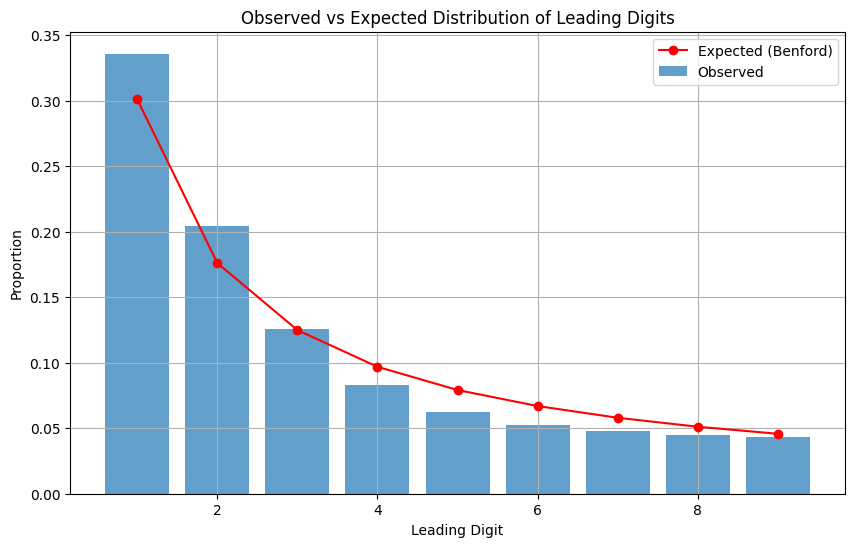

In [12]:
# Plot the observed vs expected distribution
plt.figure(figsize=(10, 6))
plt.bar(observed_counts.index, observed_probs, label='Observed', alpha=0.7)
plt.plot(range(1, 10), expected_probs, label='Expected (Benford)', color='red', marker='o')
plt.xlabel('Leading Digit')
plt.ylabel('Proportion')
plt.title('Observed vs Expected Distribution of Leading Digits')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Ensure the sum of expected counts exactly matches observed counts
if expected_counts.sum() != observed_counts.sum():
    difference = observed_counts.sum() - expected_counts.sum()
    expected_counts[0] += difference

# Statistical Test: Chi-Square Goodness of Fit
chi_stat, p_value = chisquare(f_obs=observed_counts.values, f_exp=expected_counts)
print(f"Chi-Square Statistic: {chi_stat:.4f}, P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The observed distribution significantly deviates from Benford's Law (p < 0.05). Potential anomalies detected.")
else:
    print("The observed distribution does not significantly deviate from Benford's Law (p >= 0.05).")

Chi-Square Statistic: 127489.0010, P-value: 0.0000
The observed distribution significantly deviates from Benford's Law (p < 0.05). Potential anomalies detected.


In [14]:
# Identify anomalies: significant deviations from expected counts
threshold = 0.1 * expected_counts  # 10% threshold for anomalies
anomalies = observed_counts[(observed_counts - expected_counts).abs() > threshold]
print("\nAnomalies detected:")
print(anomalies)


Anomalies detected:
amount
1    2137518
2    1302139
4     526686
5     395748
6     334283
7     305911
8     287550
Name: count, dtype: int64


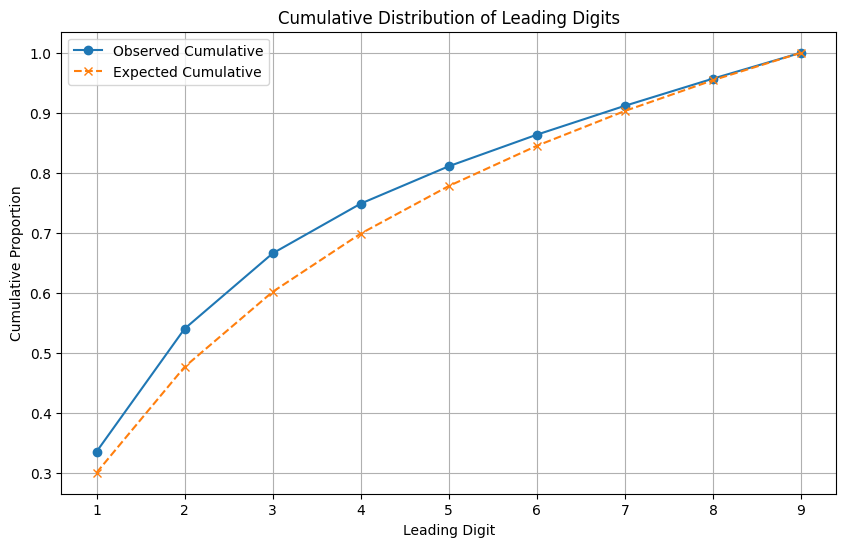

In [15]:
# Visualization: Cumulative distribution

observed_cumsum = observed_probs.cumsum()
expected_cumsum = expected_probs.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(observed_counts.index, observed_cumsum, label='Observed Cumulative', marker='o')
plt.plot(range(1, 10), expected_cumsum, label='Expected Cumulative', marker='x', linestyle='--')
plt.xlabel('Leading Digit')
plt.ylabel('Cumulative Proportion')
plt.title('Cumulative Distribution of Leading Digits')
plt.legend()
plt.grid(True)
plt.show()
